In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch

print('Torch version:', torch.__version__)
print('Cuda available:', torch.cuda.is_available())

device = 'cuda' if  torch.cuda.is_available() else 'cpu'
print('Device:', device)  # tested on cpu and cuda

Torch version: 1.7.1
Cuda available: False
Device: cpu


## Make training data

Text(0.5, 1.0, 'Ground truth (target)')

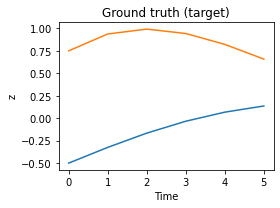

In [2]:
x_0 = torch.tensor([-.5, .75], device=device)
w = torch.tensor([[.7, .1], [-.6, .75]], device=device)

T = 5

def get_z(x):
    return 1*x

xs = [x_0]
zs = [get_z(x_0)]

for t in range(1, T+1):
    x = .1*xs[t-1] + w@zs[t-1]
    z = get_z(x)

    xs.append(x)
    zs.append(z)

xs = torch.stack(xs)
zs = torch.stack(zs)

fig, ax = plt.subplots(1, 1, figsize=(4, 3), tight_layout=True)
ax.plot(zs.detach().cpu().numpy())
ax.set_xlabel('Time')
ax.set_ylabel('z')
ax.set_title('Ground truth (target)')

## The e-prop factorization

$$\frac{dE}{dW_{ij}} = \sum_t \frac{dE}{d\hat{z}_i^t} \left[ \frac{\partial \hat{z}_i^t}{\partial W_{ij}} \right]_{local} = \sum_t \frac{dE}{d\hat{z}_i^t} e_{ij}^t$$

where

$$
e_{ij}^t = \left[ \frac{\partial \hat{z}_i^t}{\partial W_{ij}} \right]_{local} = \frac{\partial \hat{z}_i^t}{\partial \hat{x}_i^t} \sum_{t' \leq t}\frac{\partial \hat{x}_i^t}{\partial \hat{x}_i^{t-1}} \dots \frac{\partial \hat{x}_i^{t'+1}}{\partial \hat{x}_i^{t'}}
\frac{\partial \hat{x}_i^{t'}}{\partial W_{ij}}
$$


Or, in vector format (note that $\frac{dE}{d\mathbf{w}_i}$, $\mathbf{e}_i^t$, and $\boldsymbol{\epsilon}_i^t$ are all row vectors):

$$\frac{dE}{d\mathbf{w}_i} = \sum_t \frac{dE}{d\hat{z}_i^t} \left[ \frac{\partial \hat{z}_i^t}{\partial \mathbf{w}_i} \right]_{local} = \sum_t \frac{dE}{d\hat{z}_i^t} \mathbf{e}_i^t = \sum_t L_i^t \mathbf{e}_i^t$$

where

$$
\mathbf{e}_i^t = \left[ \frac{\partial \hat{z}_i^t}{\partial \mathbf{w}_i} \right]_{local} = \frac{\partial \hat{z}_i^t}{\partial \hat{x}_i^t} \sum_{t' \leq t}\frac{\partial \hat{x}_i^t}{\partial \hat{x}_i^{t-1}} \dots \frac{\partial \hat{x}_i^{t'+1}}{\partial \hat{x}_i^{t'}}
\frac{\partial \hat{x}_i^{t'}}{\partial \mathbf{w}_i}
= \frac{\partial \hat{z}_i^t}{\partial \hat{x}_i^t} \boldsymbol{\epsilon}_i^t
$$

with

$$
\boldsymbol{\epsilon}_i^t \equiv \sum_{t' \leq t}\frac{\partial \hat{x}_i^t}{\partial \hat{x}_i^{t-1}} \dots \frac{\partial \hat{x}_i^{t'+1}}{\partial \hat{x}_i^{t'}}
\frac{\partial \hat{x}_i^{t'}}{\partial \mathbf{w}_i}
$$

which can also be computed recursively:

$$
\boldsymbol{\epsilon}_i^1 = \frac{\partial \hat{x}_i^1}{\partial \mathbf{w}_i} \quad \quad \quad
\boldsymbol{\epsilon}_i^t = \frac{\partial \hat{x}_i^t}{\partial \hat{x}_i^{t-1}} \boldsymbol{\epsilon}_i^{t-1} + \frac{\partial \hat{x}_i^t}{\partial \mathbf{w}_i}
$$

Ls = [None, tensor([ 0.2685, -0.0991]), tensor([ 0.2588, -0.1692]), tensor([ 0.1820, -0.1979]), tensor([ 0.0733, -0.1757]), tensor([-0.0226, -0.1096])]
Ls_approx = [tensor([0., 0.]), tensor([ 0.0325, -0.0175]), tensor([ 0.0287, -0.0704]), tensor([ 0.0114, -0.1082]), tensor([-0.0076, -0.1198]), tensor([-0.0226, -0.1096])]
Ls = [None, tensor([0.0171, 0.0167]), tensor([0.0148, 0.0038]), tensor([-0.0003, -0.0060]), tensor([-0.0148, -0.0074]), tensor([-0.0178, -0.0031])]
Ls_approx = [tensor([0., 0.]), tensor([0.0124, 0.0138]), tensor([0.0105, 0.0088]), tensor([0.0019, 0.0003]), tensor([-0.0086, -0.0044]), tensor([-0.0178, -0.0031])]
Ls = [None, tensor([0.0091, 0.0105]), tensor([0.0082, 0.0031]), tensor([ 0.0002, -0.0033]), tensor([-0.0080, -0.0051]), tensor([-0.0099, -0.0029])]
Ls_approx = [tensor([0., 0.]), tensor([0.0062, 0.0079]), tensor([0.0059, 0.0060]), tensor([0.0017, 0.0012]), tensor([-0.0042, -0.0023]), tensor([-0.0099, -0.0029])]
Ls = [None, tensor([0.0045, 0.0060]), tensor([0.004

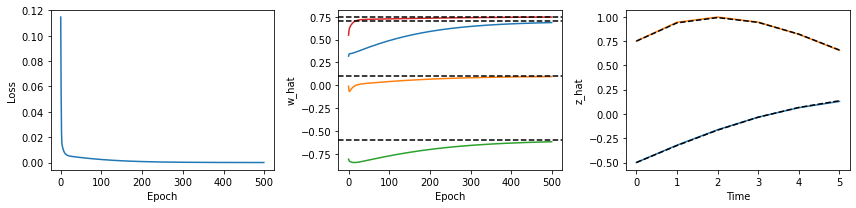

In [3]:
lr = 0.1
nepoch = 500  # change to 300 to see more difference between true and approx Ls
w_hat = torch.tensor([[.3, .05], [-.8, .5]], requires_grad=True, device=device)
w_hat_flats = np.nan*np.ones((nepoch, 4))
use_approx = False

def advance(x, z, w):
    return 0.1*x + w@z

def get_z(x):
    return 1*x

def loss_fn(z_hats, zs):
    return torch.mean((zs[1:T+1, :] - z_hats[1:T+1, :])**2)

losses = []

for epoch in range(nepoch):
    # compute first terms (dE/dx_t) using autograd
    x_hats = [x_0.clone()]
    z_hats = [x_hats[0]]

    for t in range(1, T+1):
        x_hat = advance(x_hats[t-1], z_hats[t-1], w_hat)

        z_hat = get_z(x_hat)
        z_hat.retain_grad()

        x_hats.append(x_hat)
        z_hats.append(z_hat)

    x_hats_stack = torch.stack(x_hats)
    z_hats_stack = torch.stack(z_hats)
    z_hats_stack.retain_grad()

    # backward pass for first term
    loss = loss_fn(z_hats_stack, zs)
    loss.backward(retain_graph=True)

    # get learning signals (x_hats grad)
    Ls = [z_hat.grad for z_hat in z_hats]  # ideal
    Ls_approx = [grad for grad in z_hats_stack.grad]

    if epoch%100 == 0:
        print('Ls =', Ls)
        print('Ls_approx =', Ls_approx)

    w_hat.grad.zero_()

    # # get eligibility vectors
    evs = torch.zeros((T+1, 2, 2), device=device)  # each row is an e-vector

    for t in range(1, T+1):
        partial_x_hat, partial_z_hat, partial_w_hat = torch.autograd.functional.jacobian(advance, inputs=(x_hats[t-1], z_hats[t-1], w_hat))
        # loop over neurons
        for i in range(2):
            evs[t, i, :] = partial_x_hat[i, i]*evs[t-1, i, :] + partial_w_hat[i][i, :]

    # convert to eligibility traces
    ets = 1*evs  # special case for identity activation function

    # compute gradient
    e_prop_grad = torch.zeros((2, 2), device=device)
    e_prop_grad_approx = torch.zeros((2, 2), device=device)
    for t in range(1, T+1):
        e_prop_grad += Ls[t][:, None]*ets[t, i, :]
        e_prop_grad_approx += Ls_approx[t][:, None]*ets[t, i, :]

    with torch.no_grad():
        if use_approx:
            w_hat -= lr*e_prop_grad_approx
        else:
            w_hat -= lr*e_prop_grad

    losses.append(loss.item())
    w_hat_flats[epoch, :] = w_hat.detach().cpu().numpy().flatten()

fig, axs = plt.subplots(1, 3, figsize=(12, 3), tight_layout=True)
axs[0].plot(losses)
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')

axs[1].plot(w_hat_flats)
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('w_hat')

axs[2].plot(z_hats_stack.detach().cpu().numpy())
axs[2].plot(zs.detach().cpu().numpy(), c='k', linestyle='--')
axs[2].set_xlabel('Time')
axs[2].set_ylabel('z_hat')
for w_ in w.flatten():
    axs[1].axhline(w_.item(), color='k', linestyle='--')

## Single iteration in detail

In [4]:
w_hat = torch.tensor([[.3, .05], [-.8, .5]], requires_grad=True, device=device)

def advance(x, z, w):
    return 0.1*x + w@z

def get_z(x):
    return 1*x

def loss_fn(z_hats, zs):
    return torch.mean((zs[1:T+1, :] - z_hats[1:T+1, :])**2)

# compute first terms (dE/dx_t) using autograd
x_hats = [x_0.clone()]
z_hats = [x_hats[0]]

for t in range(1, T+1):
    x_hat = advance(x_hats[t-1], z_hats[t-1], w_hat)
    x_hat.retain_grad()

    z_hat = get_z(x_hat)
    z_hat.retain_grad()

    x_hats.append(x_hat)
    z_hats.append(z_hat)

x_hats_stack = torch.stack(x_hats)
z_hats_stack = torch.stack(z_hats)
z_hats_stack.retain_grad()

# backward pass for first term
loss = loss_fn(z_hats_stack, zs)
loss.backward(retain_graph=True)

grad_bptt = w_hat.grad.clone()
print('w_hat.grad using BPTT:\n', grad_bptt, '\n')

# get learning signals (x_hats grad)
Ls = [z_hat.grad for z_hat in z_hats]
print('Learning signals (Total derivatives of loss wrt z_hat_t):\n', Ls, '\n')

# Ls_approx = [grad for grad in torch.autograd.functional.jacobian(loss_fn, inputs=(z_hats_stack, zs))[0]]
Ls_approx = [grad for grad in z_hats_stack.grad]
print('Approx learning signals (Partial derivatives):\n', Ls_approx, '\n')

w_hat.grad.zero_()

### DEBUGGING
jac_x_hat_wrt_w_hats = []

for t in range(1, T+1):
    jac = torch.autograd.functional.jacobian(advance, inputs=(x_hats[t-1], z_hats[t-1], w_hat))[2].reshape((2, 4))

    jac_x_hat_wrt_w_hats.append(jac)

summands = [x_hat.grad@jac for x_hat, jac in zip(x_hats[1:], jac_x_hat_wrt_w_hats)]
w_hat_grad = torch.stack(summands).sum(dim=0).reshape((2, 2))

print('Classical factorization gradient:\n', w_hat_grad, '\n')
### END DEBUG

# # get eligibility vectors
evs = torch.zeros((T+1, 2, 2), device=device)  # each row is an e-vector

for t in range(1, T+1):
    partial_x_hat, partial_z_hat, partial_w_hat = torch.autograd.functional.jacobian(advance, inputs=(x_hats[t-1], z_hats[t-1], w_hat))
    # loop over neurons
    for i in range(2):
        evs[t, i, :] = partial_x_hat[i, i]*evs[t-1, i, :] + partial_w_hat[i][i, :]

# convert to eligibility traces

ets = 1*evs  # special case for identity activation function

# compute gradient
e_prop_grad = torch.zeros((2, 2), device=device)
e_prop_grad_approx = torch.zeros((2, 2), device=device)
for t in range(1, T+1):
    e_prop_grad += Ls[t][:, None]*ets[t, i, :]
    e_prop_grad_approx += Ls_approx[t][:, None]*ets[t, i, :]

print('E-prop gradient (ideal):\n', e_prop_grad, '\n')
print('E-prop gradient (approx):\n', e_prop_grad_approx, '\n')

w_hat.grad using BPTT:
 tensor([[-0.1965,  0.6028],
        [ 0.0875, -0.4889]]) 

Learning signals (Total derivatives of loss wrt z_hat_t):
 [None, tensor([ 0.2685, -0.0991]), tensor([ 0.2588, -0.1692]), tensor([ 0.1820, -0.1979]), tensor([ 0.0733, -0.1757]), tensor([-0.0226, -0.1096])] 

Approx learning signals (Partial derivatives):
 [tensor([0., 0.]), tensor([ 0.0325, -0.0175]), tensor([ 0.0287, -0.0704]), tensor([ 0.0114, -0.1082]), tensor([-0.0076, -0.1198]), tensor([-0.0226, -0.1096])] 

Classical factorization gradient:
 tensor([[-0.1965,  0.6028],
        [ 0.0875, -0.4889]]) 

E-prop gradient (ideal):
 tensor([[-0.1965,  0.6028],
        [ 0.0875, -0.4889]]) 

E-prop gradient (approx):
 tensor([[-0.0237,  0.0496],
        [ 0.0228, -0.2440]]) 



## Classical BPTT factorization

x_hats [[-0.5         0.75      ]
 [-0.16250001  0.84999996]
 [-0.02250001  0.64      ]
 [ 0.023       0.402     ]
 [ 0.0293      0.22280002]
 [ 0.02286     0.11024   ]]
w_hat.grad = [[-0.19654685  0.6027708 ]
 [ 0.08746339 -0.48894495]]


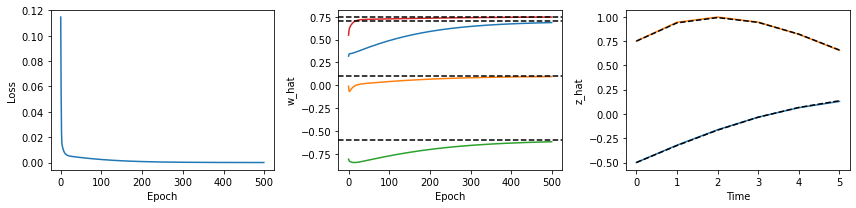

In [5]:
lr = 0.1
nepoch = 500

w_hat = torch.tensor([[.3, .05], [-.8, .5]], requires_grad=True, device=device)
w_hat_flats = np.nan*np.ones((nepoch, 4))

def advance(x, z, w):
    return .1*x + w@z

def get_z(x):
    return 1*x

def loss_fn(z_hats, zs):
    return torch.mean((zs[1:, :] - z_hats[1:, :])**2)

losses = []

for epoch in range(nepoch):

    # compute first terms (dE/dx_t) using autograd
    ## forward pass
    x_hats = [x_0.clone()]
    z_hats = [get_z(x_hats[0])]

    for t in range(1, T+1):
        x_hat = advance(x_hats[t-1], z_hats[t-1], w_hat)
        x_hat.retain_grad()

        z_hat = get_z(x_hat)

        x_hats.append(x_hat)
        z_hats.append(z_hat)

    x_hats_stack = torch.stack(x_hats)
    z_hats_stack = torch.stack(z_hats)

    ## backward pass
    loss = loss_fn(z_hats_stack, zs)
    loss.backward(retain_graph=True)

    jac_x_hat_wrt_w_hats = []

    for t in range(1, T+1):
        jac = torch.autograd.functional.jacobian(advance, inputs=(x_hats[t-1], z_hats[t-1], w_hat))[2].reshape((2, 4))

        jac_x_hat_wrt_w_hats.append(jac)

    summands = [x_hat.grad@jac for x_hat, jac in zip(x_hats[1:], jac_x_hat_wrt_w_hats)]
    w_hat_grad = torch.stack(summands).sum(dim=0).reshape((2, 2))

    # weight update
    with torch.no_grad():
        w_hat -= lr*w_hat_grad
        if epoch == 0:
            print('x_hats', x_hats_stack.detach().cpu().numpy())
            print('w_hat.grad =', w_hat_grad.detach().cpu().numpy())
        w_hat.grad.zero_()

    losses.append(loss.item())
    w_hat_flats[epoch, :] = w_hat.detach().cpu().numpy().flatten()

fig, axs = plt.subplots(1, 3, figsize=(12, 3), tight_layout=True)
axs[0].plot(losses)
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')

axs[1].plot(w_hat_flats)
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('w_hat')

axs[2].plot(z_hats_stack.detach().cpu().numpy())
axs[2].plot(zs.detach().cpu().numpy(), c='k', linestyle='--')
axs[2].set_xlabel('Time')
axs[2].set_ylabel('z_hat')
for w_ in w.flatten():
    axs[1].axhline(w_.item(), color='k', linestyle='--')